## Finalizing thesis diagrams

This notebook will finalize diagrams for the thesis to insure that all use the same grouping of elements. This will slice the dataframe by one year and add the diagrams.

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg
import descartes

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

In [3]:
from scipy.interpolate import interpn

### Comparison to literature

In [4]:
# σ0 < 27.8 kg m−3	
# σ0 urn:x-wiley:21699275:media:jgrc22386:jgrc22386-math-0009 27.8 kg m−3

# d < 2000 m

# σ0 urn:x-wiley:21699275:media:jgrc22386:jgrc22386-math-0010 27.8 kg m−3

# d urn:x-wiley:21699275:media:jgrc22386:jgrc22386-math-0011 2000 
                    
buo = np.where(rho_pot0[-1]<27.8)
dens = np.where(rho_pot0[-1]>=27.8)
deep = np.where(depth[-1]<=-2000)

densdeep = np.intersect1d(dens,deep)
print(len(buo[0])/5460)
print((len(dens[0])-len(densdeep))/5460)
print(len(densdeep)/5460)

NameError: name 'rho_pot0' is not defined

In [65]:
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values

xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]
[Xbins, Ybins] = np.meshgrid(ybins,xbins)

stack = np.stack((ygrid, xgrid), axis=-1)
stack.shape

lat2 = interpn((ybins,xbins),lat_values,stack)
long2 = interpn((ybins,xbins),long_values,stack)

In [69]:
# check how often AABW forms in different parts
aabw = np.where(wmt[-1]== 0)
aabw = aabw[0]

latpts = np.array([])
lonpts = np.array([])

for idx in aabw:
    # get the first x and y value where wmt == 0 for each 
    thisarr = np.where(wmt[:,idx] == 0)
    latpts = np.append(latpts,lat2[:,idx][thisarr[0][0]])
    lonpts = np.append(lonpts,long2[:,idx][thisarr[0][0]])

In [79]:
lonx = np.where(lonpts>65)
len(lonx[0])/len(lonpts)

0.15205992509363295

### Slice the points by one year, load the release points, load the dataframe for KMeans

In [4]:
# load the libraries
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/muramarg/copied_files/waom10extend_grd.nc')

In [5]:
# slice the floats by one year
idx_arr = np.empty((2,5460),dtype=int)
x = ds.variables["Xgrid"].values
for i in range(idx_arr.shape[1]):
    # get the indices in that row in the xgrid
    thisrow = x[:,i]
    nonna = thisrow[~np.isnan(thisrow)]
    startidx = len(thisrow)-len(nonna)
    endidx = int(startidx + ((86400/900)*365))
    idx_arr[0][i] = startidx
    idx_arr[1][i] = endidx

# select the initial columns of values (at all times)
all_xgrid = ds.variables['Xgrid'].values
all_ygrid = ds.variables['Ygrid'].values
all_salt = ds.variables['salt'].values
all_temp = ds.variables['temp'].values
all_depth = ds.variables['depth'].values
all_dens = ds.variables['rho'].values

# create the new grids of only single year values
xgrid = np.empty((35040,5460))
ygrid = np.empty((35040,5460))
salt = np.empty((35040,5460))
temp = np.empty((35040,5460))
depth = np.empty((35040,5460))
dens = np.empty((35040,5460))

# select in the ds.xgrid and ds.ygrid based on the values in the idx_arr
for i in range(idx_arr.shape[1]):
    idxs = idx_arr[:,i]
    thisx = all_xgrid[:,i][idxs[0]:idxs[1]]
    thisy = all_ygrid[:,i][idxs[0]:idxs[1]]
    thissalt = all_salt[:,i][idxs[0]:idxs[1]]
    thistemp = all_temp[:,i][idxs[0]:idxs[1]]
    thisdept = all_depth[:,i][idxs[0]:idxs[1]]
    thisdens = all_dens[:,i][idxs[0]:idxs[1]]
    
    # add these values to our new xgrid and ygrid for one year
    xgrid[:,i] = thisx
    ygrid[:,i] = thisy
    salt[:,i] = thissalt
    temp[:,i] = thistemp
    depth[:,i] = thisdept
    dens[:,i] = thisdens

In [6]:
# convert the waom values to gsw values
# convert depth to sea pressure
long = 73.5089
lat = -66.8245
p = gsw.p_from_z(z=depth,lat=-66.8245)


# convert the absolute salinity from practical salinity
SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# find the potential density from SA, CT, p
rho_pot = gsw.rho(SA,CT,p) - 1000

In [7]:
# convert the absolute salinity from practical salinity
long = 73.5089
lat = -66.8245
p0 = np.zeros(depth.shape)
SA0 = gsw.SA_from_SP(salt,p0,long,lat)    # absolute salinity from practical salinity

# convert potential T to conservative T
CT0 = gsw.CT_from_pt(SA0,temp)   # conservative T from potential T
rho_pot0 = gsw.rho(SA0,CT0,p0) - 1000

In [8]:
# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

In [9]:
# # test reading the file
with open("/scratch/project_2000789/muramarg/KMeans/text_files/wm_file_year4.txt","r") as f:
# # with open("wm_alter.txt","r") as f:
    a = f.readlines()
    wm_arr = np.empty((35040,5460))
    for i in range(35040):
        b = a[i].split(" ")
        b = np.asarray(b)
        b[-1] = b[-1][:-1]
        b = b.astype(int)
        wm_arr[i] = b
f.close()

wm_arr[wm_arr == 6] = 3
wm_arr[wm_arr == 7] = 2
wm_arr[wm_arr == 8] = 6

In [10]:
wmt = np.fromfile("/scratch/project_2000789/muramarg/KMeans/text_files/wmt4.txt",sep=",")
wmt = wmt.reshape((35040,5460))

wmt[wm_arr == 2] = 2
wmt[wm_arr == 1] = 1

## Create the polygons as a diagram of starting points

## Plot the 2x2 residence time diagrams and density map

In [44]:
# residence time
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]

# index of bins the particles ending in
x_new = np.digitize(xgrid,xbins)
y_new = np.digitize(ygrid,ybins)

# create an empty array for the bin time
m2 = []
for i in range(len(xbins)):
    newl = []
    for j in range(len(ybins)):
        newl.append([])
    m2.append(newl)
    
# each bin has an average or total time that any one particle spends in it
# for each column
start_time = time.time()
for i in range(x_new.shape[1]):
#for i in range(5):
    if i % 1000 == 0:
        print(i,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # get the x and y column values
    thisx = x_new[:,i]
    thisy = y_new[:,i]

    # make a stack of the x and y columns
    pts = np.vstack((thisx,thisy))
    pts = pts.T

    # normalize to the total number of particles
    counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
    counts.pop()
    
    # add each count to a list in the mesh
    for ii in counts[:-1]:
        iind = ii[0][0]
        jind = ii[0][1]
        
        # create the mesh without the scaling by time
        myval = (ii[1]*900)/86400 # current sum of the column totals

        # see if the current number of the mesh is zero, if it is, add to list
        #print(m2[iind][jind])
        
        m2[int(iind)][int(jind)].append(myval)

0 of 5460 in 2.8332074483235676e-06
1000 of 5460 in 0.3651299118995667
2000 of 5460 in 0.7288013696670532
3000 of 5460 in 1.1084315458933511
4000 of 5460 in 1.4802799622217815
5000 of 5460 in 1.8450784921646117


In [45]:
# AVERAGE MESH
mesh = np.zeros((len(xbins),len(ybins)))

# create the mesh based on averages of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = sum(m2[ii][jj])/len(m2[ii][jj])
            if avg<200:
                mesh[ii][jj] = avg
            #else:
                #print(avg)
                
# MAX MESH
mesh_max = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = max(m2[ii][jj])
            #print(avg)
            mesh_max[ii][jj] = avg
            #else:
            #    print(avg)

# MIN MESH
mesh_min = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = min(m2[ii][jj])
            if avg<200:
                mesh_min[ii][jj] = avg
            #else:
            #    print(avg)

# STDEV MESH
mesh_std = np.zeros((len(xbins),len(ybins)))
# create the mesh based on maximum values of m2
for ii in range(len(m2)):
    for jj in range(len(m2[ii])):
        if len(m2[ii][jj])>0:
            avg = np.std(m2[ii][jj])
            #if avg<200:
            mesh_std[ii][jj] = avg
            
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

# write the mesh to a text file
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

(630, 560)
(560, 630)


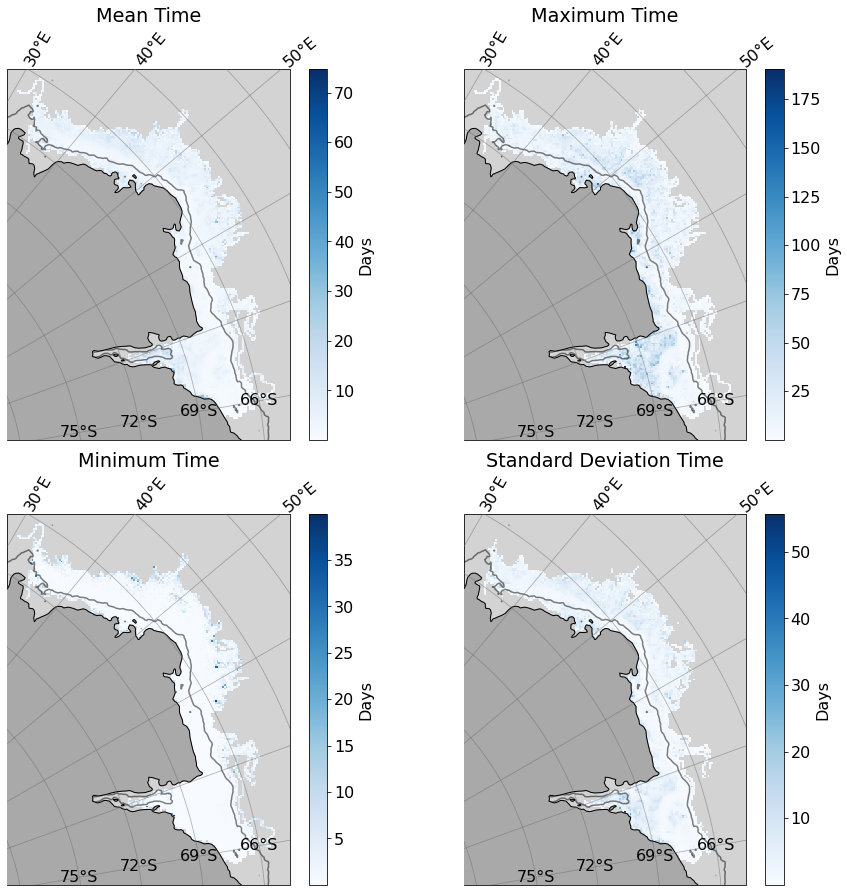

In [323]:
# FOR PRESENTATION
# average values
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(2, 2, 1, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Mean Time")
plt.colorbar(label="Days")

ax = fig.add_subplot(2, 2, 2, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh_max[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Maximum Time")
plt.colorbar(label="Days")

ax = fig.add_subplot(2, 2, 3, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh_min[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Minimum Time")
plt.colorbar(label="Days")

ax = fig.add_subplot(2, 2, 4, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
plt.rcParams.update({'font.size': 16})
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh_std[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001)
plt.title("Standard Deviation Time")
plt.colorbar(label="Days")

plt.savefig('/scratch/project_2000789/muramarg/KMeans/formeeting_328/res_time4.png',dpi=300)

In [54]:
# create the density map
x_sing = np.array([])
y_sing = np.array([])
start_time = time.time()
for col in range(x_new.shape[1]):
    if col % 500 == 0:
        print(col,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # create a set of datapoints
    thisx = (x_new[:,col])
    thisy = (y_new[:,col])
    
    # create the array of the colum
    arr = np.vstack((thisx,thisy))
    arr = arr.T
    
    # create a set from the array so each coordinate visits each grid square once
    set_coords = list(set(map(tuple,arr)))
    for myset in set_coords:
        x_sing = np.append(x_sing,myset[0])
        y_sing = np.append(y_sing,myset[1])
        
pts = np.vstack((x_sing,y_sing))
pts = pts.T

# normalize to the total number of particles
counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
num_positions = len(counts)
#print(counts)
print(num_positions)

# pop the nan values
counts.pop()

# we are dividing by the number of particles, not number of positions
num_particles = 5460
print(num_particles)

mesh = np.zeros((len(xbins),len(ybins)))

for ii in counts[:-1]:
    iind = ii[0][0]
    jind = ii[0][1]
    # create the mesh without the scaling by time
    myval = ii[1]/num_particles
    
    # scale by time for one day
    myval = (myval/900)*86400
    
    mesh[int(iind)][int(jind)] = myval
    
    # 
mesh

[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

0 of 5460 in 1.7841657002766927e-06
500 of 5460 in 0.2742136279741923
1000 of 5460 in 0.8769145806630453
1500 of 5460 in 1.7439167102177937
2000 of 5460 in 2.9058497190475463
2500 of 5460 in 4.49282503525416
3000 of 5460 in 6.286433486143748
3500 of 5460 in 8.424454581737518
4000 of 5460 in 10.925767083962759
4500 of 5460 in 13.540766068299611
5000 of 5460 in 16.50828358332316
6534
5460
(630, 560)
(560, 630)


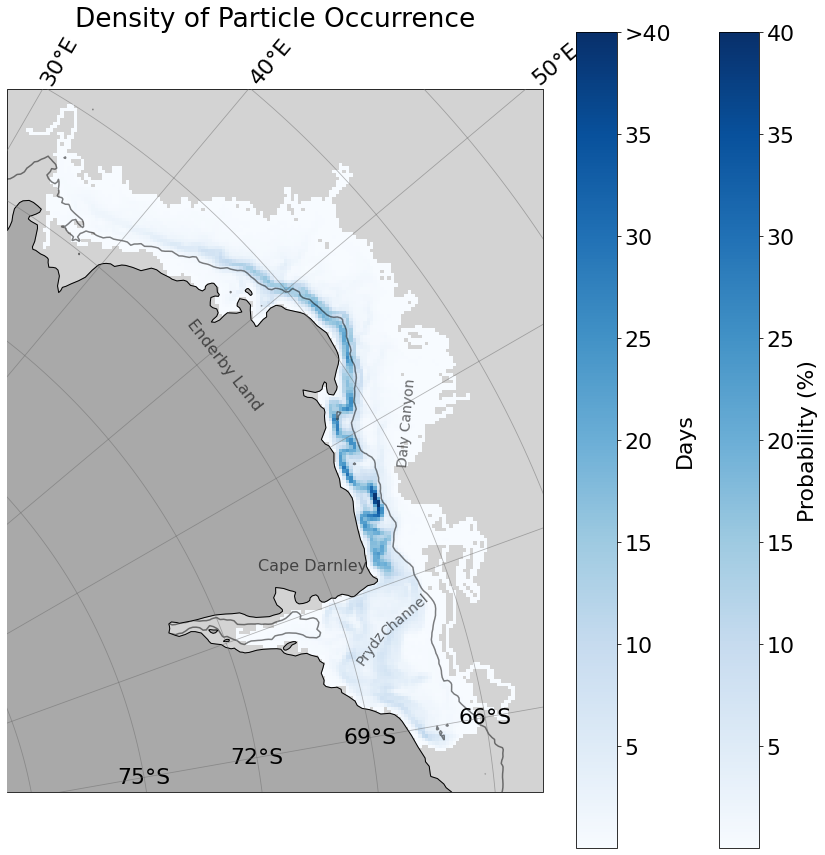

In [19]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=proj) 
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])
# xlimit = np.arange(300,500,1)
# ylimit = np.arange(450,630,1)
#a = plt.contour(dg.lon_rho[470:500,400:410], dg.lat_rho[470:500,400:410],ds1.zice[70:500,400:410],levels=[-0.2],zorder=2,linestyles='dashed', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
#b = plt.contour(dg.lon_rho[470:,400:410], dg.lat_rho[470:,400:410],ds1.h[470:,400:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)

cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
#plt.contour(p[-1])
#plt.contour(v)

plt.rcParams.update({'font.size': 22})

ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5)
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)

cmap = mpl.cm.get_cmap("Blues").copy()
cmap.set_under(color='lightgray')
#plt.contour(v,transform=ccrs.PlateCarree())


plt.pcolormesh(long[420:580,300:530],lat[420:580,300:530],mesh[420:580,300:530],transform=ccrs.PlateCarree(),zorder=1,cmap=cmap,vmin=0.0000001,vmax=40)
plt.title("Density of Particle Occurrence")
cbar = plt.colorbar(ticks=[5,10,15,20,25,30,35,40],label="Probability (%)")
cbar.ax.set_yticklabels(["5","10","15","20","25","30","35",">40"])  # vertically oriented colorbar

plt.text(x=52, y=-70,s="Enderby Land",transform=ccrs.PlateCarree(),rotation=-52,fontsize=16,alpha=0.6)
plt.text(x=65.5, y=-70.5,s="Cape Darnley",transform=ccrs.PlateCarree(),rotation=0,fontsize=16,alpha=0.6)
plt.text(x=74.6, y=-69,s="Prydz",transform=ccrs.PlateCarree(),rotation=-305,fontsize=14,alpha=0.6)
plt.text(x=73.1, y=-68.2,s="Channel",transform=ccrs.PlateCarree(),rotation=-320,fontsize=14,alpha=0.6)
plt.text(x=63, y=-66.1,s="Daly Canyon",transform=ccrs.PlateCarree(),rotation=-275,fontsize=14,alpha=0.6)

#plt.xlim()
plt.savefig('/scratch/project_2000789/muramarg/KMeans/formeeting_328/method2_writing.png')

## Polynya Locations

In [11]:
# show the release points with bathymetry
with open("/users/muramarg/points.txt","r") as f:
    lines = f.readlines()
f.close()
lines = lines[2:]
xfirst = np.array([])
yfirst = np.array([])
for i in range(len(lines)):
    xi = float(lines[i][:5])
    yi = float(lines[i][-6:-1])
    xfirst = np.append(xfirst,xi)
    yfirst = np.append(yfirst,yi)

(250000.0, 2350000.0)

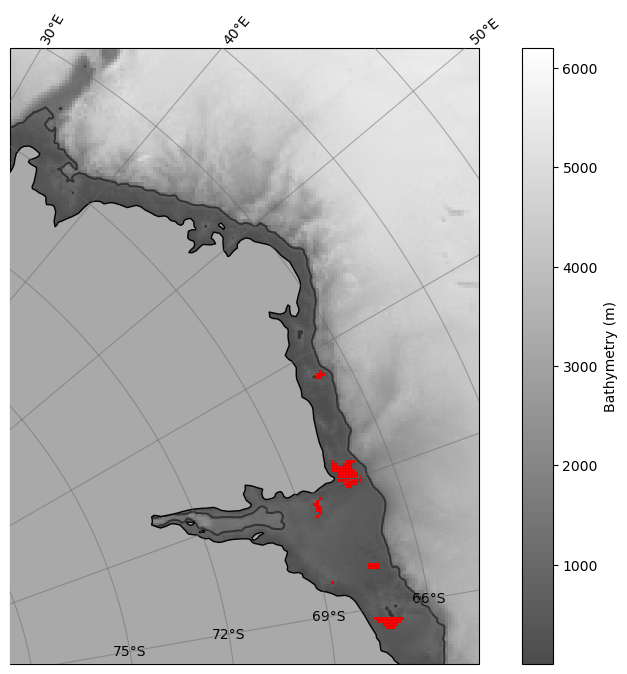

In [32]:
# THESE ARE IN GRID POINTS
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1, 1, 1,projection=proj)

# add the points
plt.scatter(long2[0],lat2[0],transform=ccrs.PlateCarree(),color="red",s=0.1,zorder=10,marker='o')
#plt.plot(long2[:100],lat2[:100],marker = '.',markersize=1, color='red',transform=ccrs.PlateCarree(),zorder=9,alpha=0.6)

#plt.plot(xgrid[0],ygrid[0],'o',markersize=0.1,c="blue",zorder=10,transform=ccrs.PlateCarree())
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Bathymetry (m)')
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# add the polygons for polynya shapes
# BARRIER: x[540:560], y[330:342]
# sx = np.array([541,555,555,541])
# sy = np.array([334,334,341,341])
# b = np.array([[a,b] for a,b in zip(sx,sy)])
# barrier = sg.Polygon(b)
# barrier1 = ax.add_patch(descartes.PolygonPatch(barrier, fc='none', ec='blue', alpha=1,label="Barrier"))

# # DARNLEY: x[525:540], y[380:400]
# sx = np.array([527,538,538,527])
# sy = np.array([381,381,395,395])
# d = np.array([[a,b] for a,b in zip(sx,sy)])
# darnley = sg.Polygon(d)
# darnley1 = ax.add_patch(descartes.PolygonPatch(darnley, fc='none', ec='green', alpha=1,label="Darnley"))

# # DAVIS: x[525:530], y[345:355]
# sx = np.array([525,530,530,525])
# sy = np.array([346,346,355,355])
# da = np.array([[a,b] for a,b in zip(sx,sy)])
# davis = sg.Polygon(da)
# davis1 = ax.add_patch(descartes.PolygonPatch(davis, fc='none', ec='orange', alpha=1,label="Davis"))

# # MACKENZIE: x[520:530], y[370,380]
# sx = np.array([521,526,526,521])
# sy = np.array([370,370,381,381])
# m = np.array([[a,b] for a,b in zip(sx,sy)])
# mackenzie = sg.Polygon(m)
# mackenzie1 = ax.add_patch(descartes.PolygonPatch(mackenzie, fc='none', ec='purple', alpha=1,label="MacKenzie"))

# ax = plt.gca()
# ax.gridlines(draw_labels=True,zorder=10)
# #ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=0)
# #ax.coastlines(zorder=5,facecolor='black',edgecolor='black')

# plt.legend(loc="best")
# plt.savefig("/scratch/project_2000789/muramarg/KMeans/formeeting_2_27/polynyas.png", dpi=300)
# plt.show()

## Polygons

In [11]:
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti1 = np.linspace(-3,3.3,ydim)
si1 = np.linspace(31,38,xdim)
Freez_temp = gsw.CT_freezing(si1,0,0)

Si, Ti = np.meshgrid(si1, ti1, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si1[i],ti1[j],0)
        # Substract 1000 to convert to sigma-0
dens = dens - 1000

# convert to practical/potential
ti = gsw.pt_from_CT(si1,ti1)
si = gsw.SP_from_SA(si1,0,long,lat)

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 38.38


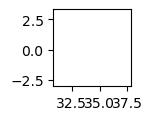

In [12]:
# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the density vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,36,36,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
aabw = c.intersection(d)

# find the winter water values
cs = ax.contourf(si, ti, dens, levels=[27.55,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1.5,-1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
ww = a.intersection(b)

# find the mcdw values
cs = ax.contourf(si, ti, dens, levels=[27.73,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# find the dsw values
cs = ax.contourf(si, ti, dens, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# ftmax = Freez_temp+0.1
# ftmin = Freez_temp-0.5
# ft = np.append(ftmax,np.flip(ftmin))
# si2 = si.copy()
# si2 = np.append(si2,np.flip(si2))
# b = np.array([[a,b] for a,b in zip(si2,ft)])
sx = np.array([35,35,31,31])
sy = np.array([-3,-1.7,-1.7,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
#dsw = b.intersection(c)
dsw = b.intersection(a)

# find the aasw values
cs = ax.contourf(si, ti, dens, levels=[24,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in density
sx = np.array([34.5,34.5,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# find the msw values
cs = ax.contourf(si, ti, dens, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp + 0.1
ft = np.append(ft,[-0.4,-0.4])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
#dsw = b.intersection(c)
msw = c.intersection(a)
msw = msw.difference(dsw)

# add ISW values
cs = ax.contourf(si, ti, dens, levels=[25,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
isw = b.intersection(a)
#isw = isw.difference(dsw)
isw = isw.difference(aabw)
#ucdw = ucdw.difference(mcdw)
aasw = aasw.difference(ww)
#aasw = aasw.difference(ucdw)

# find the aaiw values
cs = ax.contourf(si, ti, dens, levels=[27.2,27.4],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in density
sx = np.array([34.6,34.6,32,32])
sy = np.array([2,3.5,3.5,2])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aaiw = d.intersection(a)

In [13]:
saltflat = salt.flatten()
tempflat = temp.flatten()

In [14]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


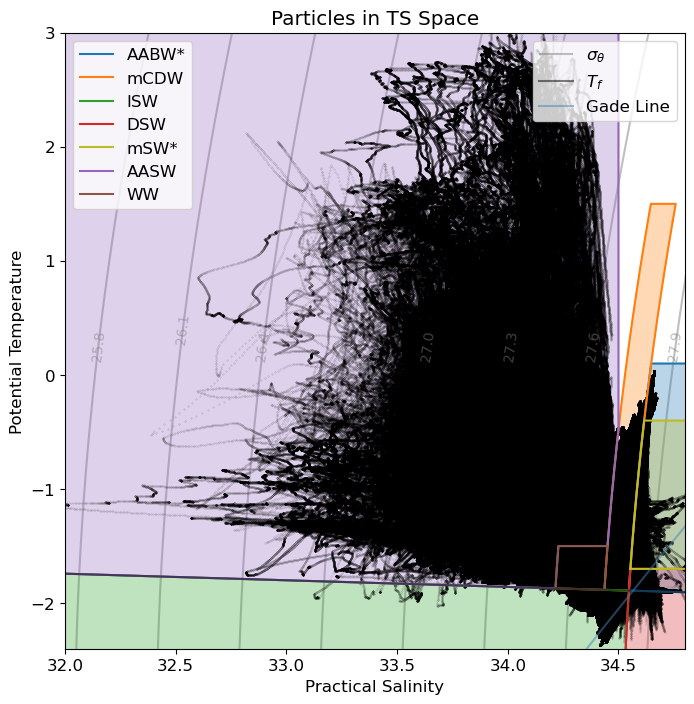

In [16]:
#POLYGONS
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
# plt.ylim(-2.4,max(ti))
# plt.xlim(32,34.8)
plt.ylim(-2.4,3)
plt.xlim(32,34.8)
shapes = np.array([])
shapelabels = np.array([])
# plt.plot(salt_flat,temp_flat,'o',markersize=0.1,zorder=0)
plt.rcParams.update({'font.size': 15})


plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens, colors="grey", zorder=1,alpha=0.5,levels=np.arange(24,28.5,0.3))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# add the freezing temperature
fline = plt.plot(si,Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=7)
gadeline = plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=8)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")
h = np.append(h,gadeline)
l = np.append(l,"Gade Line")

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue")
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange")
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green")
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red")
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW*",color="tab:olive")
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple")
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW",color="tab:brown")
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=1)
plt.gca().add_artist(legend1)
plt.legend(shapes,shapelabels, loc="best")

# plt.title("Neutral and potential density of water masses")
plt.title("Particles in TS Space")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

s = np.array([34.6,34.6])
t = np.array([1,-0.6])
#plt.scatter(s,t)

plt.scatter(saltflat,tempflat,s=0.05,marker='o',color="black",alpha=0.3)

plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/polygons_final.png", dpi=300)
plt.show()

## Add the mean pathways for the final 3 months

In [17]:
group0 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group0.txt",sep=",")
group1 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group1.txt",sep=",")
group2 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group2.txt",sep=",")
group3 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group3.txt",sep=",")
group4 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group4.txt",sep=",")
group5 = np.fromfile("/scratch/project_2000789/muramarg/KMeans/FINAL/group5.txt",sep=",")

group0 = group0.tolist()
group0 = [int(x) for x in group0]
group1 = group1.tolist()
group1 = [int(x) for x in group1]
group2 = group2.tolist()
group2 = [int(x) for x in group2]
group3 = group3.tolist()
group3 = [int(x) for x in group3]
group4 = group4.tolist()
group4 = [int(x) for x in group4]
group5 = group5.tolist()
group5 = [int(x) for x in group5]

groups = np.array([group0,group1,group2,group3,group4,group5],dtype=object)

In [18]:
tests0 = np.mean(salt[:,group0][-17280:],axis=0)
testt0 = np.mean(temp[:,group0][-17280:],axis=0)

tests1 = np.mean(salt[:,group1][-17280:],axis=0)
testt1 = np.mean(temp[:,group1][-17280:],axis=0)

tests2 = np.mean(salt[:,group2][-17280:],axis=0)
testt2 = np.mean(temp[:,group2][-17280:],axis=0)

tests3 = np.mean(salt[:,group3][-17280:],axis=0)
testt3 = np.mean(temp[:,group3][-17280:],axis=0)

tests4 = np.mean(salt[:,group4][-17280:],axis=0)
testt4 = np.mean(temp[:,group4][-17280:],axis=0)

tests5 = np.mean(salt[:,group5][-17280:],axis=0)
testt5 = np.mean(temp[:,group5][-17280:],axis=0)

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

y = tests0.reshape(len(tests0),1)
xfit0 = testt0.reshape(len(tests0),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit0)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit0)
yfit0 = reg.predict(X_vals_poly)

y = tests1.reshape(len(tests1),1)
xfit1 = testt1.reshape(len(tests1),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit1)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit1)
yfit1 = reg.predict(X_vals_poly)

y = tests2.reshape(len(tests2),1)
xfit2 = testt2.reshape(len(tests2),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit2)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit2)
yfit2 = reg.predict(X_vals_poly)

y = tests3.reshape(len(tests3),1)
xfit3 = testt3.reshape(len(tests3),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit3)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit3)
yfit3 = reg.predict(X_vals_poly)

y = tests4.reshape(len(tests4),1)
xfit4 = testt4.reshape(len(tests4),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit4)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit4)
yfit4 = reg.predict(X_vals_poly)

y = tests5.reshape(len(tests5),1)
xfit5 = testt5.reshape(len(tests5),1)
poly_features = PolynomialFeatures(degree = 5, include_bias = False)
X_poly = poly_features.fit_transform(xfit5)
reg = LinearRegression()
reg.fit(X_poly,y)
X_vals_poly = poly_features.transform(xfit5)
yfit5 = reg.predict(X_vals_poly)

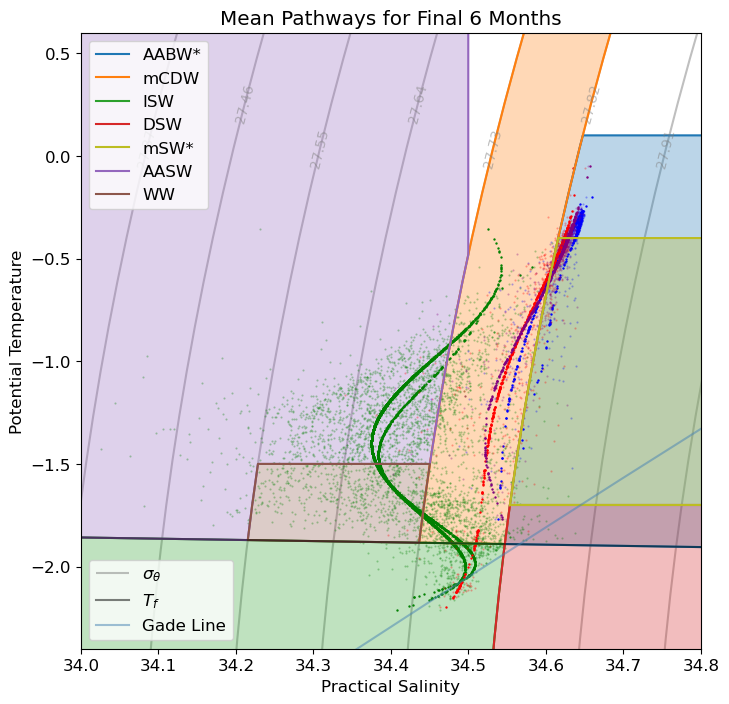

In [21]:
#POLYGONS


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
# plt.ylim(-2.4,max(ti))
# plt.xlim(32,34.8)
plt.ylim(-2.4,0.6)
plt.xlim(34,34.8)
shapes = np.array([])
shapelabels = np.array([])
# plt.plot(salt_flat,temp_flat,'o',markersize=0.1,zorder=0)
plt.rcParams.update({'font.size': 15})


plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens, colors="grey", zorder=1,alpha=0.5,levels=[27.37,27.46,27.55,27.64,27.73,27.82,27.91,28])
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# add the neutral density lines
# cs = ax.contour(si, ti, dens_neut,colors="black", zorder=1,alpha=0.5,linestyles='-.')
# cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
# a,b = cs.legend_elements()
# a = np.array([a[0]],dtype=object)
# b = np.array(["$\gamma$"])
# h = np.append(h,a[0])
# l = np.append(l,b[0])

# add the freezing temperature
#Freez_temp = gsw.CT_freezing(np.linspace(31,35,xdim),0,0)
fline = plt.plot(si,Freez_temp,'-',color='black',label="$T_{f}$",alpha=0.5,zorder=7)
gadeline = plt.plot(si,Tgade,'-',color='steelblue',label='Gade Line',alpha=0.5,zorder=8)
h = np.append(h,fline)
l = np.append(l,"$T_{f}$")
h = np.append(h,gadeline)
l = np.append(l,"Gade Line")

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue")
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange")
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green")
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red")
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW*",color="tab:olive")
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple")
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW",color="tab:brown")
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=3)
plt.gca().add_artist(legend1)
plt.legend(shapes,shapelabels, loc="best")

# plt.title("Neutral and potential density of water masses")
plt.title("Mean Pathways for Final 6 Months")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

plt.scatter(tests0,testt0,s=0.3,marker='o',color="green",label="Group 1",alpha=0.3)
plt.scatter(yfit0,xfit0,s=0.5,marker='o',color="green",label="Group 1")
plt.scatter(tests1,testt1,s=0.3,marker='o',color="green",label="Group 2",alpha=0.3)
plt.scatter(yfit1,xfit1,s=0.5,marker='o',color="green",label="Group 2")
plt.scatter(tests2,testt2,s=0.3,marker='o',color="blue",label="Group 3",alpha=0.3)
plt.scatter(yfit2,xfit2,s=0.5,marker='o',color="blue",label="Group 3")
plt.scatter(tests3,testt3,s=0.3,marker='o',color="blue",label="Group 4",alpha=0.3)
plt.scatter(yfit3,xfit3,s=0.5,marker='o',color="blue",label="Group 4")
plt.scatter(tests4,testt4,s=0.3,marker='o',color="red",label="Group 5",alpha=0.3)
plt.scatter(yfit4,xfit4,s=0.5,marker='o',color="red",label="Group 5")
plt.scatter(tests5,testt5,s=0.3,marker='o',color="purple",label="Group 6",alpha=0.3)
plt.scatter(yfit5,xfit5,s=0.5,marker='o',color="purple",label="Group 6")

plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/mean_pathways_final.png", dpi=300)
plt.show()

In [175]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


## Now create the grouping

In [62]:
# quality of the grouping
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
WW_percents = np.array([])
other_percents = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    #thismass = wmt[-1][group]
    thismass = wmt[0][group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(7):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
            
    # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is hssw, 7 is lssw
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 5:
            WW_percents = np.append(WW_percents,counts_elements[i])
        elif unique_elements[i] == 6:
            other_percents = np.append(other_percents,counts_elements[i])

In [63]:
wmt_df = pd.DataFrame()
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["WW"] = WW_percents
wmt_df["other"] = other_percents
wmt_df

,# of particles,AABW,MCDW,ISW,DSW,AASW,WW,other
0,947.0,0.0,146.0,0.0,0.0,797.0,0.0,4.0
1,2934.0,0.0,849.0,3.0,898.0,341.0,53.0,790.0
2,282.0,0.0,67.0,0.0,88.0,40.0,2.0,85.0
3,262.0,0.0,48.0,0.0,92.0,43.0,1.0,78.0
4,567.0,0.0,117.0,0.0,202.0,83.0,6.0,159.0
5,468.0,0.0,70.0,0.0,158.0,79.0,4.0,157.0


## Create grouped plots

In [52]:
depth_pres = depth*-0.1

In [53]:
# depth v rho colored by time
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400

time1 = x_time0.astype(int)

1
2
3
4
5
6


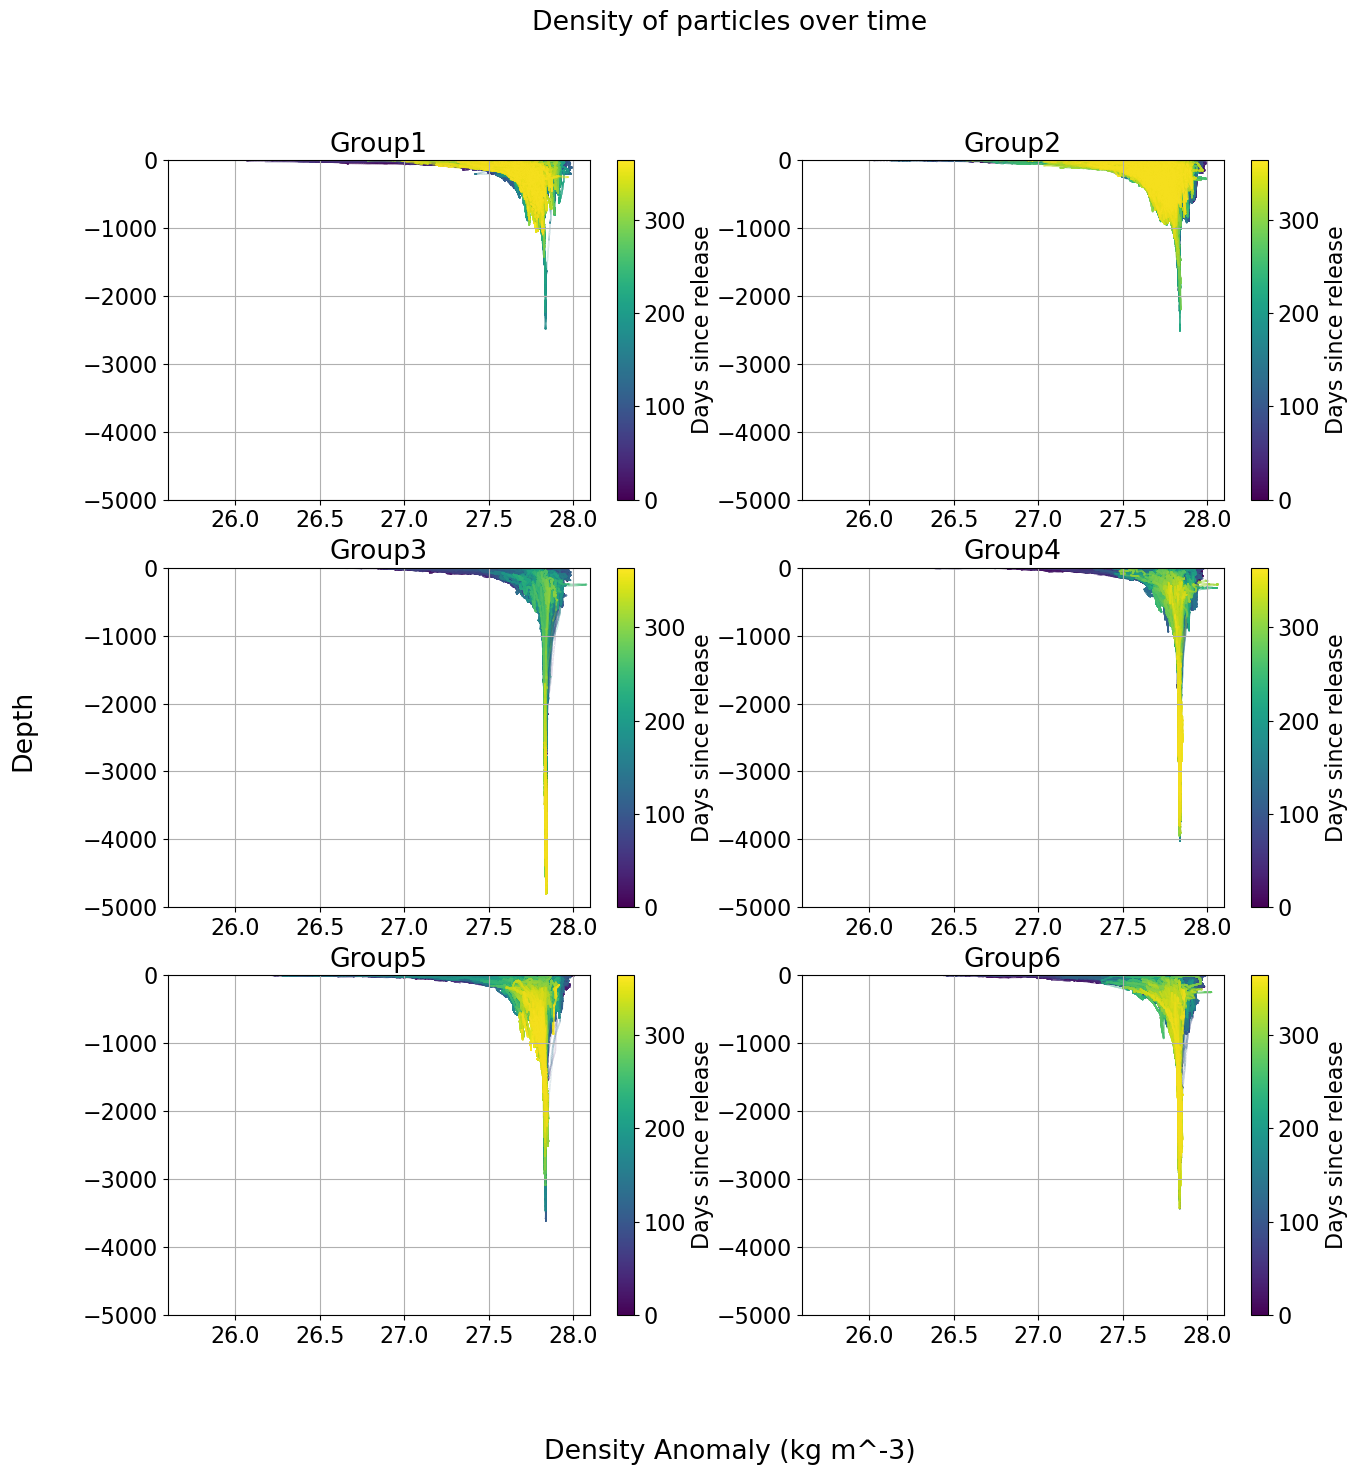

In [60]:
# plot 2 by 3 of density with depth over time of the groupings
fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)
i = 1

plt.rcParams.update({'font.size': 16})
fig.suptitle("Density of particles over time")
fig.supxlabel('Density Anomaly (kg m^-3)')
fig.supylabel('Depth')

for group in groups:
    print(i)
    ax = fig.add_subplot(3, 2, i)
    plt.grid()
    plt.xlim(25.6,28.1)
    plt.ylim(-5000, 0)                         # normalize the depth
    plt.scatter(rho_pot0[:,group],depth[:,group],marker=".",s=0.01,c=time1[:,group])
    #plt.scatter(rho_pot[:,group][0],depth[:,group][0],marker="x",c="green",label="Start")
    #plt.scatter(pot_dens[:,group][-1],depth[:,group][-1],marker="x",c="red",label="End")
    #plt.legend(loc="best")
    plt.title("Group " + str(i) + ": " + str(len(group)))
    
    #im2 = ax.imshow(m2, interpolation='None')
    cbar = plt.colorbar(label="Days since release")
    #cbar = plt.colorbar(ticks=[0, 0.2,0.4,0.6,0.8,1],label='Days since release')
    #cbar.set_ticklabels([0,73,146,219,292,365])
    
    i += 1
# plt.show()
plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/depthvgamma_1.png", dpi=300)

1
2
3
4
5
6


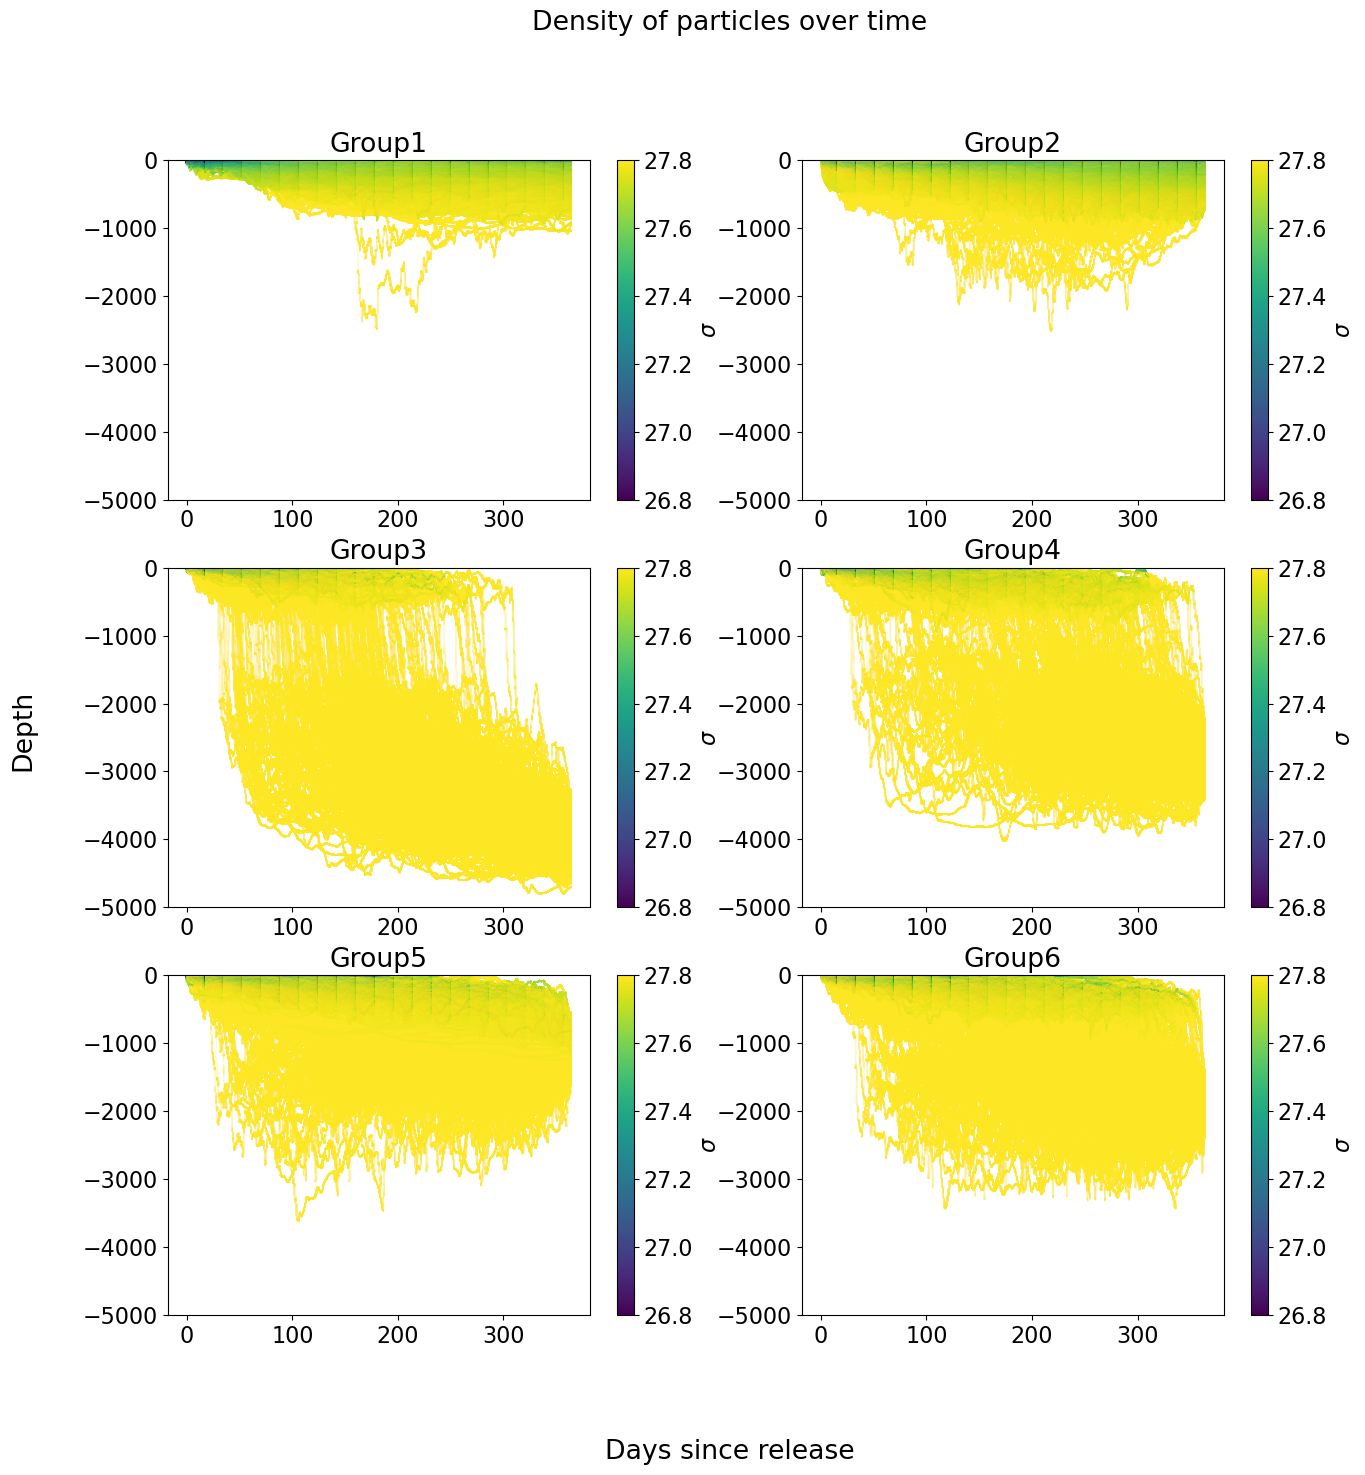

In [59]:
# plot rho with depth
time = temp.shape[0]
time = np.arange(0,time,1)
x_time0 = np.tile(time,(depth.shape[1],1))
x_time0 = x_time0.T   # this will be our time matrix to color the numbers
x_time0 = x_time0*900/86400
time1 = x_time0.astype(int)

fig = plt.figure(figsize=(15,15))
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 16})
i = 1

fig.suptitle("Density of particles over time")
fig.supxlabel('Days since release')
fig.supylabel('Depth')

for group in groups:
    print(i)
    ax = fig.add_subplot(3, 2, i)
    plt.ylim(-5000, 0)
    plt.scatter(time1[:,group],depth[:,group],marker=".",s=0.01,c=rho_pot0[:,group],vmin=26.8,vmax=27.8)
    plt.title("Group " + str(i) + ": " + str(len(group)))
    plt.colorbar(label=''r'$\sigma$')
    i += 1
# plt.show()
plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/rho_over_time_1.png", dpi=300)

## Seasonal distribution

In [14]:
# seasonal distributions of the groups
# this says months but really it is a distribution of them by 13 4-week intervals
# find the repeating releases for each of the 105 points
month_idx = np.arange(0,52) #(13,8760)
x = 0
m = 1
for i in range(len(month_idx)):
    month_idx[i] = m
    
    x += 1
    if x == 4:
        x = 0
        m += 1
# repeat this for the 105 points
df_months_i = np.array([])
for i in range(105):
    df_months_i = np.append(df_months_i,month_idx)

unique, counts = np.unique(df_months_i, return_counts=True)
print(unique,counts)

df_months_i[df_months_i==13].shape

for group in groups:
    print(df_months_i[group][df_months_i[group] == 13].shape)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.] [420 420 420 420 420 420 420 420 420 420 420 420 420]
(85,)
(269,)
(15,)
(15,)
(19,)
(17,)


In [15]:
# # Distribution of Various Quantities
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm

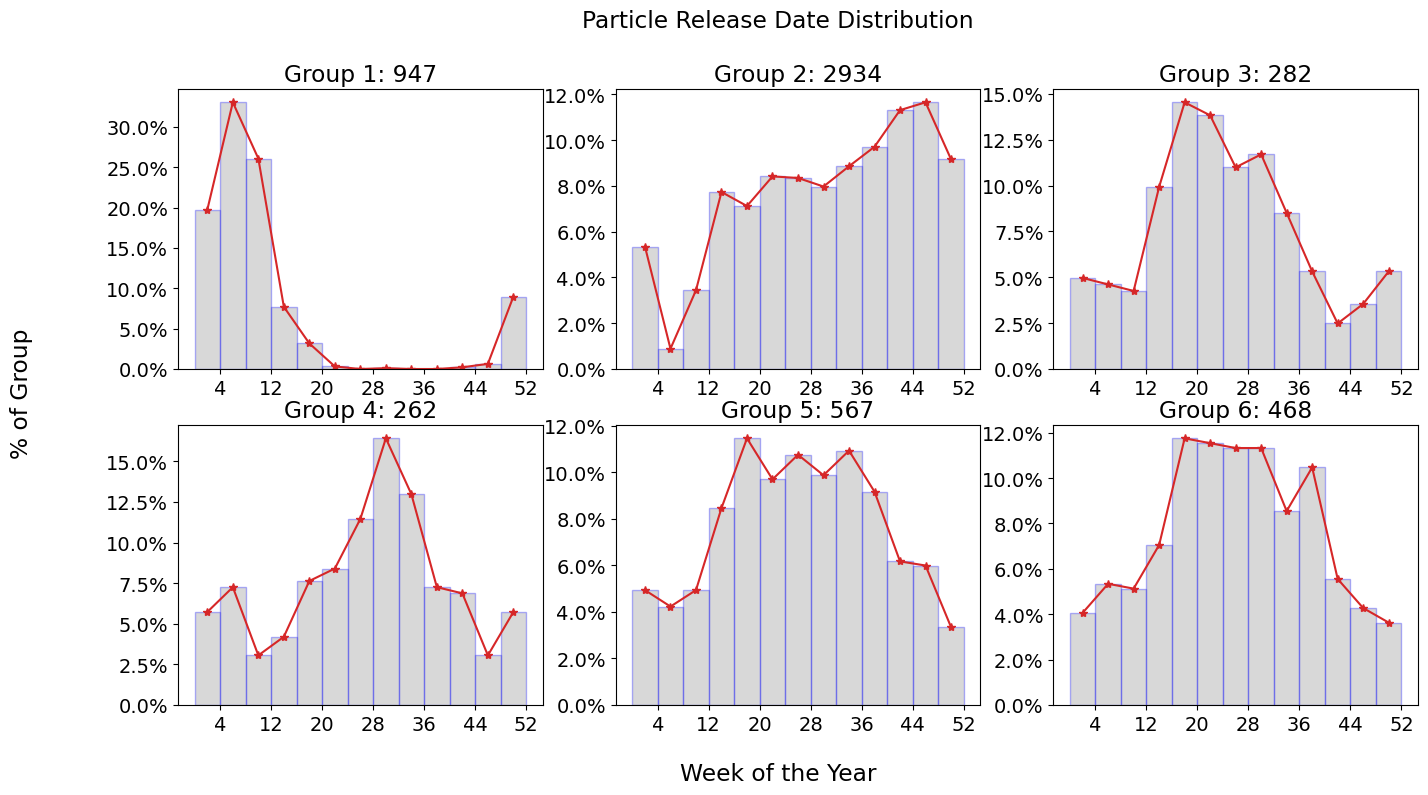

In [18]:
fig = plt.figure(figsize = (16,8))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})
plt.suptitle("Particle Release Date Distribution")
fig.supxlabel('Week of the Year')
fig.supylabel('% of Group')
i = 1


for group in groups:
    ax = fig.add_subplot(2, 3, i)
    y,edges,_ = ax.hist(df_months_i[group],alpha=0.3,edgecolor="blue",facecolor="gray",bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14],weights=np.ones(len(df_months_i[group])) / len(df_months_i[group]))
    mystr = "Group " + str(i) + ": " + str(len(group))
    plt.xticks(ticks=[2,4,6,8,10,12,14],labels=[4,12,20,28,36,44,52])
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.xticks()
    plt.title(mystr)
    i  += 1
    
    # Plot the PDF.
    #mu, std = norm.fit(df_months_i[group])
    #xmin, xmax = plt.xlim()
    #x = np.linspace(xmin, xmax, 100)
    #p = norm.pdf(x, mu, std)
    #plt.plot(x, p, 'k', linewidth=2)
    
    #y,edges,_ = plt.hist(test_scores1, bins)
    xcenters = (edges[:-1] + edges[1:]) / 2
    #y,edges = np.histogram(df_months_i[group], bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    #centers = 0.5*(edges[1:]+ edges[:-1])
    ax.plot(xcenters,y,'-*',color="tab:red")
    
plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/months_dist_perc.png", dpi=300)

### Eulerian view of the particles

In [35]:
cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red","tab:purple","tab:brown","tab:olive"])

In [ ]:
# THESE ARE IN GRID POINTS
# plot all the groups colored by the water mass grid
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
#ax = fig.add_subplot(1, 1, 1,projection=proj)

# group0
ax = fig.add_subplot(2, 3, 1,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 1: "+ str(len(group0)))
plt.scatter(long2[:,group0],lat2[:,group0],marker='.',s=0.1,zorder=10,c=wmt[:,group0],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group1
ax = fig.add_subplot(2, 3, 2,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 2: "+ str(len(group1)))
plt.scatter(long2[:,group1],lat2[:,group1],marker='.',s=0.1,zorder=10,c=wmt[:,group1],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group2
ax = fig.add_subplot(2, 3, 3,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 3: "+ str(len(group2)))
plt.scatter(long2[:,group2],lat2[:,group2],marker='.',s=0.1,zorder=10,c=wmt[:,group2],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group3
ax = fig.add_subplot(2, 3, 4,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 4: "+ str(len(group3)))
plt.scatter(long2[:,group3],lat2[:,group3],marker='.',s=0.1,zorder=10,c=wmt[:,group3],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group4
ax = fig.add_subplot(2, 3, 5,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 5: "+ str(len(group4)))
plt.scatter(long2[:,group4],lat2[:,group4],marker='.',s=0.1,zorder=10,c=wmt[:,group4],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

# group5
ax = fig.add_subplot(2, 3, 6,projection=proj)
plt.rcParams.update({'font.size': 15})
plt.title("Group 6: "+ str(len(group5)))
plt.scatter(long2[:,group5],lat2[:,group5],marker='.',s=0.1,zorder=10,c=wmt[:,group5],cmap=cmap,transform=ccrs.PlateCarree())
labels=["AABW","mCDW","ISW","DSW","AASW","WW","mSW"]
cbar = plt.colorbar(ticks=[0,1,2,3,4,5,6])
cbar.ax.set_yticklabels(labels)
plt.pcolormesh(dg.lon_rho,dg.lat_rho,ds1.h.isel(),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('gray'),alpha=0.7)
plt.grid()
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')
cs = plt.contour(dg.lon_rho[300:,350:], dg.lat_rho[300:,350:],dg.h[300:,350:],levels=[1000],zorder=2, linestyles='solid', transform=ccrs.PlateCarree(), colors="black",alpha=0.5)
ax = plt.gca()
ax.gridlines(draw_labels=True,zorder=10,color="dimgray",alpha=0.5,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='darkgray',zorder=3)
plt.xlim([1250000,2850000])
plt.ylim([250000,2350000])

plt.savefig("/scratch/project_2000789/muramarg/KMeans/FINAL/wmt_colored_group_replaced.png", dpi=300)

Error in callback <function flush_figures at 0x7f06b303ab00> (for post_execute):
